# 🧹 Preprocessing  
Notebook ini digunakan untuk menuliskan proses preprocessing data sebelum dilakukan pemodelan prediksi keterlambatan pengiriman barang.

Langkah-langkah preprocessing yang dilakukan meliputi:

- **Load dataset** menggunakan pandas dari file CSV
- **Penanganan missing value** menggunakan SimpleImputer untuk mengisi nilai kosong
- **Transformasi kolom tanggal** ke format datetime agar bisa digunakan dalam analisis dan pemodelan
- **Pembuatan target variable** `Late Delivery` berdasarkan perbandingan antara tanggal yang dijanjikan dan tanggal aktual pengiriman
- **Drop fitur-fitur yang tidak relevan** atau berpotensi menyebabkan data leakage
- **Normalisasi data numerik** menggunakan StandardScaler agar skala data seimbang
- **Encoding data kategorikal** dengan one-hot encoding
- **Split data** ke dalam data latih dan data uji untuk kebutuhan pemodelan

Seluruh proses ini bertujuan untuk memastikan bahwa data sudah bersih, relevan, dan siap digunakan dalam proses training model klasifikasi.

In [1]:
# STEP 1: Import Library yang Dibutuhkan
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# STEP 2: Load Dataset
df = pd.read_csv('../data/raw/SCMS_Delivery_History_Dataset.csv')
print("Jumlah baris & kolom:", df.shape)
df.head()

Jumlah baris & kolom: (10324, 33)


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [3]:
# STEP 3: HANDLE / mengisi MISSING VALUES ===
df['Shipment Mode'] = df['Shipment Mode'].fillna('Unknown') #Kolom teks diisi dengan Unkonown
df['Dosage'] = df['Dosage'].fillna('Unknown')
df['Line Item Insurance (USD)'] = df['Line Item Insurance (USD)'].fillna(df['Line Item Insurance (USD)'].median()) #Kolom teks diisi dengan median

In [4]:
# STEP 4: DROP KODE TRANSAKSI YANG TERLALU SPESIFIK ===
# Beberapa kolom ID, deskripsi produk, dan informasi vendor dihapus karena tidak
# memberikan nilai prediktif / gak penting.
drop_cols = [col for col in df.columns if 'PQ' in col or 'PO' in col or 'ASN' in col]
drop_cols += ['ID', 'Project Code', 'Item Description', 'Brand', 'Vendor', 'Molecule/Test Type', 'Manufacturing Site']

In [6]:
# STEP 5: KONVERSI KOLOM NUMERIK ===
# Kolom berat dan biaya pengiriman diubah ke format numerik (float), dengan mengabaikan nilai yang gagal diubah.
df['Weight (Kilograms)'] = pd.to_numeric(df['Weight (Kilograms)'], errors='coerce')
df['Freight Cost (USD)'] = pd.to_numeric(df['Freight Cost (USD)'], errors='coerce')

In [7]:
# STEP 6: KONVERSI TANGGAL + HITUNG DELIVERY DELAY ===
# Tanggal dijadwalkan dan tanggal aktual dikonversi ke format datetime, kemudian dihitung selisihnya dalam hari sebagai Delivery Delay.
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'], format='%d-%b-%y', errors='coerce')
df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'], format='%d-%b-%y', errors='coerce')
df['Delivery Delay'] = (df['Delivered to Client Date'] - df['Scheduled Delivery Date']).dt.days

In [8]:
# STEP 7: TARGET: LATE DELIVERY ===
# Label target dibuat: 1 jika pengiriman terlambat, 0 jika tidak terlambat.
df['Late Delivery'] = df['Delivery Delay'].apply(lambda x: 1 if pd.notnull(x) and x > 0 else 0)

In [9]:
# STEP 8: FEATURE: DELIVERY MONTH ===
# Membuat fitur baru Delivery Month dari kolom tanggal pengiriman yang dijadwalkan.
df['Delivery Month'] = df['Scheduled Delivery Date'].dt.month

In [10]:
# STEP 9: NORMALISASI NUMERIK ===
# Semua fitur numerik dinormalisasi ke rentang 0–1 menggunakan MinMaxScaler
# agar model tidak bias / terpengaruh terhadap nilai besar.
numerical_cols = ['Line Item Value', 'Pack Price', 'Unit Price', 'Freight Cost (USD)', 'Weight (Kilograms)']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

In [11]:
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [12]:
# STEP 10: ONE-HOT ENCODING ===
# Kolom bertipe teks seperti negara, mode pengiriman, dll dikonversi ke bentuk numerik menggunakan One-Hot Encoding.
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols)

In [13]:
# STEP 11: DROP KOLOM YANG MENYEBABKAN LEAKAGE ===
# Kolom yang mengandung informasi jawaban atau waktu aktual dihapus dari fitur (X) agar model tidak "curang".
leakage_cols = ['Late Delivery', 'Delivery Delay', 'Delivered to Client Date', 'Delivery Recorded Date']
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
cols_to_drop = [col for col in leakage_cols + datetime_cols if col in df.columns]
X = df.drop(columns=cols_to_drop)
y = df['Late Delivery']

# ✅ Hapus baris yang masih mengandung NaN
X = X.dropna()
y = y.loc[X.index]

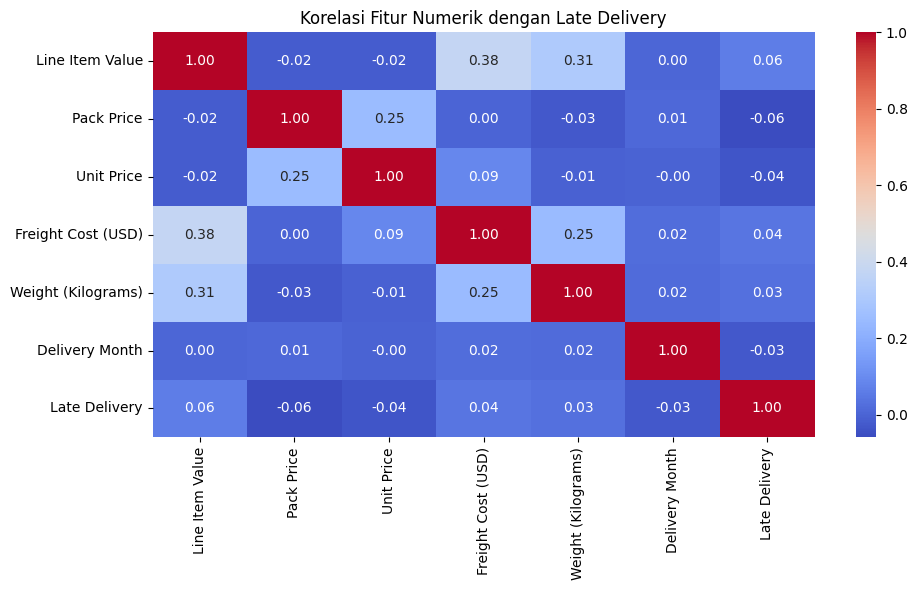

In [14]:
# STEP 12: Correlation analysis
# Pastikan kolom numerikal yang dipakai sudah ada dan tidak mengandung NaN
numerical_cols = ['Line Item Value', 'Pack Price', 'Unit Price',
                  'Freight Cost (USD)', 'Weight (Kilograms)', 'Delivery Month']

# Drop baris dengan NaN di kolom yang dianalisis agar korelasi valid
corr_data = df[numerical_cols + ['Late Delivery']].dropna()

# Plot heatmap korelasi
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Korelasi Fitur Numerik dengan Late Delivery')
plt.tight_layout()
plt.show()